It'd be nice to be able to find the target automatically, so we can just point it at a directory and stack them.  In this case, the target is just Jupiter, so we only need to look for a bright blob someplace.  That's not too hard to do:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import rawpy

In [8]:
import scipy.signal

In [3]:
def load_rgb(path, yrange=None, xrange=None):
    raw = rawpy.imread(path)
    rgb = raw.postprocess(demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR,
                      output_bps=16, no_auto_bright=True, gamma=(2.5,3)).astype('float')

    if xrange and yrange:
        jupiter = rgb[yrange[0]:yrange[1],xrange[0]:xrange[1],:]
    else:
        jupiter = rgb
    return jupiter

def load_lum(path, yrange=None, xrange=None):
    jupiter = load_rgb(path, yrange, xrange)
    def lum(img):
        coeffs = [0.299, 0.587, 0.114 ]

        retval = np.zeros_like(img[:,:,0])
        for i, c_i in enumerate(coeffs):
            retval += c_i * img[:,:,i] # **2

        return retval # np.sqrt(retval)
    return lum(jupiter)

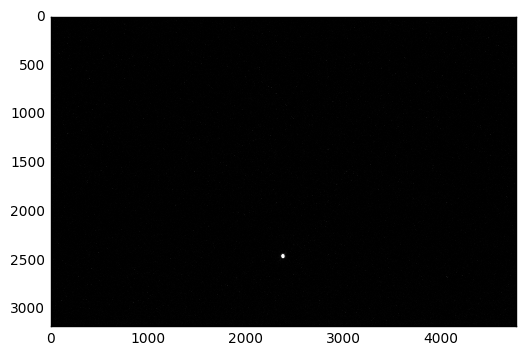

In [7]:
x = load_lum("/home/jbm/Desktop/101CANON/buckets/1div4_5.7_1600_300.0/IMG_0134.CR2")
imshow(x, cmap=cm.gray)

In [21]:
def find_target(x, tdim, downsample):
    # Implements a quick-and-dirty convolution with a tdim x tdim array of ones.
    
    if x.shape[0] <= tdim or x.shape[1] <= tdim:
        return None

    if 1 != downsample:
        ds_retval = find_target(x[::downsample, ::downsample], tdim/downsample, 1)
        return (downsample*ds_retval[0], downsample*ds_retval[1])
    
    sums = np.zeros((x.shape[0]-tdim, x.shape[1]-tdim))
    
    for d0 in range(tdim):
        for d1 in range(tdim):
            sums += x[d0:(d0-tdim),d1:(d1-tdim)]
            
    th = tdim/2
    
    maxloc = np.argmax(sums)
    maxind = np.unravel_index(maxloc, sums.shape)
    
    return (maxind[0]+th, maxind[1]+th)

In [24]:
%time find_target(x,20,3)

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 185 ms


(2457, 2376)

In [25]:
def find_target_conv(x, tdim, downsample):
    if x.shape[0] <= tdim or x.shape[1] <= tdim:
        return None

    if 1 != downsample:
        ds_retval = find_target(x[::downsample, ::downsample], tdim/downsample, 1)
        return (downsample*ds_retval[0], downsample*ds_retval[1])

    k = np.zeros((tdim,tdim))
    k += 1
    sums = scipy.signal.convolve2d(x, k, mode='same')
    maxloc = np.argmax(sums)
    maxind = np.unravel_index(maxloc, sums.shape)
    
    return (maxind[0], maxind[1])

In [26]:
%time find_target_conv(x, 20, 3)

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 176 ms


(2457, 2376)

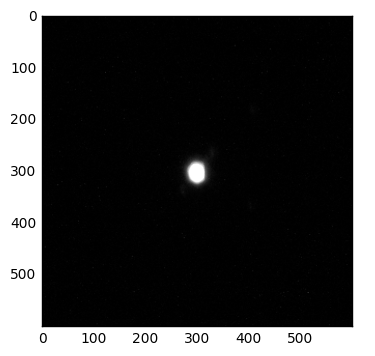

In [28]:
ty,tx = find_target(x,20,3)
margin=300


imshow(x[(ty-margin):(ty+margin),(tx-margin):(tx+margin)], cmap=cm.gray)